An autoencoder is a special type of neural network that is trained to copy its input to its output. For example, given an image of a handwritten digit, an autoencoder first encodes the image into a lower dimensional representation, then decodes it back to an image. It learns to compress the data while minimizing the reconstruction error. This notebook uses autoencoders for detecting anomaly in ECG(electro cardiogram) readings. This is a very good practical application of autoencoders. So lets begin!

Here is my github profile: https://github.com/Devavrata-Tripathy

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow.keras import layers, losses
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model

In [ ]:
df = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
df.head()

As we can see that the dataset has 140 columns which represent the ECG readings and a labels column which has been encoded to 0 or 1 showing whether the ECG is abnormal or normal.

In [ ]:
#Now we will separate the data and labels so that it will be easy for us
data = df.iloc[:,:-1].values
labels = df.iloc[:,-1].values
labels

In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = 0.2, random_state = 21)

**Lets normalize the data to the range [0-1]**

We will use the simple formula :-
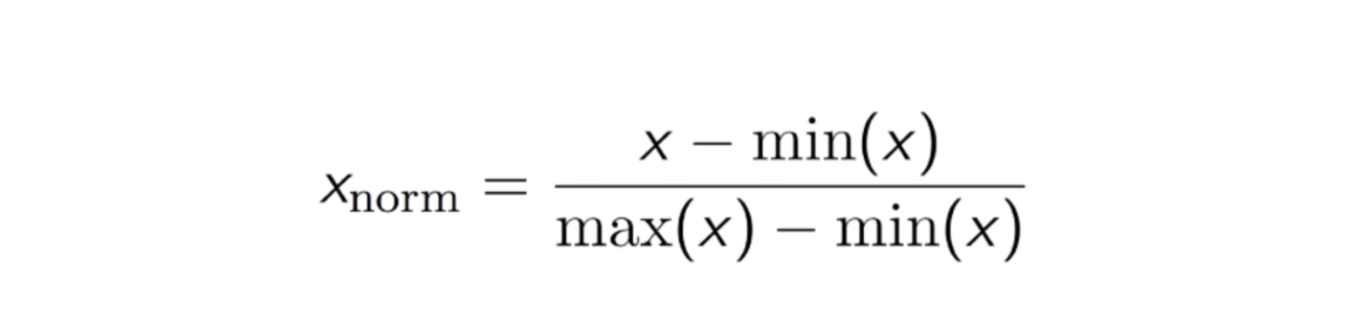

In [ ]:
#Now lets Normalize the data
#First we will calculate the maximum and minimum value from the training set 
min = tf.reduce_min(train_data)
max = tf.reduce_max(train_data)

#Now we will use the formula (data - min)/(max - min)
train_data = (train_data - min)/(max - min)
test_data = (test_data - min)/(max - min)

#I have converted the data into float
train_data = tf.cast(train_data, dtype=tf.float32)
test_data = tf.cast(test_data, dtype=tf.float32)

In [ ]:
#The labels are either 0 or 1, so I will convert them into boolean(true or false) 
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

#Now let's separate the data for normal ECG from that of abnormal ones
#Normal ECG data
n_train_data = train_data[train_labels]
n_test_data = test_data[test_labels]

#Abnormal ECG data
an_train_data = train_data[~train_labels]
an_test_data = test_data[~test_labels]

print(n_train_data)

In [ ]:
#Lets plot a normal ECG
plt.plot(np.arange(140), n_train_data[0])
plt.grid()
plt.title('Normal ECG')
plt.show()

In [ ]:
#Lets plot one from abnormal ECG
plt.plot(np.arange(140), an_train_data[0])
plt.grid()
plt.title('Abnormal ECG')
plt.show()

**This model uses an Autoencoder architecture for anomaly detection**

Autoencoders are a specific type of feedforward neural network.It compresess the input into a so-called "code" of lower dimensionality and then tries to reconstruct the output from this code.It is an **unsupervised** learning model. 

It consists of two parts:-
1.Encoder
2.Decoder

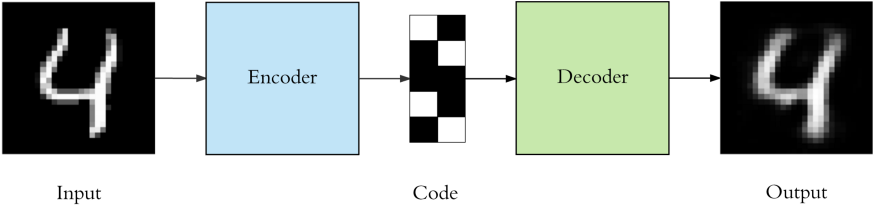

So in simple terms we provide an input to the autoencoder and it tries to re-create it.

For a detailed information refer to the article in link https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798



**So how the model will detect anomaly ?**

We will create an encoder and a decoder using an ANN architecture.We are going to provide the ECG data as input and the model will try to reconstruct it. The error between the original data and reconstructed output will be called the **reconstruction error**.Based on this recostruction error we are going to classify an ECG as anomalous or not.In order to do this we are going to train the model only on the normal ECG data but it will be tested on the full test set, so that when an abnormal ECG is provided in the input the autoencoder will try to reconstruct it but since it has been only trained on normal ECG data the output will have a larger reconstruction error. We will also define a minimum threshold for the error i.e. if the reconstruction error is above the threshold then it will be categorised as anomalous. 

Before we make the model another thing that I want to clarify is that I will be using the **Subclassing API** of keras for making the model.
In keras there are mainly 3 APIs for defining a model :-
**1.Sequential API
2.Functional API
3.Subclassing API

The reason I used Subclassing API is that it provides a good control over the model as compared to Sequential API because in sequential API the add funcion implicitly passes the output of one layer into the next and u just get the output from the final layer but in case  of subclassing API the forward pass is explicitly defined as you can see in the **call()** function. For this problem this api suits best. 

The subclassing api is used to create a model class called **detector**(in this case) it inherits from the **Model** class of keras from which both sequential model and functional api also inherit. First using super() we pass the parameters to the parent class then we define out constructor which has the encoder and decoder. Then we implement the forward pass in the call() function. 

For a better understanding refer to this article https://towardsdatascience.com/3-ways-to-create-a-machine-learning-model-with-keras-and-tensorflow-2-0-de09323af4d3

In [ ]:
#Now let's define the model!
#Here I have used the Model Subclassing API (but we can also use the Sequential API)
#The model has 2 parts : 1. Encoder and 2. Decoder
 
class detector(Model):
  def __init__(self):
    super(detector, self).__init__()
    self.encoder = tf.keras.Sequential([
                                        layers.Dense(32, activation='relu'),
                                        layers.Dense(16, activation='relu'),
                                        layers.Dense(8, activation='relu')
    ])
    self.decoder = tf.keras.Sequential([
                                        layers.Dense(16, activation='relu'),
                                        layers.Dense(32, activation='relu'),
                                        layers.Dense(140, activation='sigmoid')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

**NOTE**:
See that in fit() both the data are same i.e. n_train_data, the reason is that we will be comparing the original ECG with the reconstructed one to calculate the reconstruction error.
Autoencoders are unsupervised learning models but here we are training them using supervised method so its more like they are used as **self-supervised**.  

In [ ]:
#Let's compile and train the model!!
autoencoder = detector()
autoencoder.compile(optimizer='adam', loss='mae')
autoencoder.fit(n_train_data, n_train_data, epochs = 20, batch_size=512, validation_data=(n_test_data, n_test_data))

In [ ]:
#Now let's define a function in order to plot the original ECG and reconstructed ones and also show the error
def plot(data, n):
  enc_img = autoencoder.encoder(data)
  dec_img = autoencoder.decoder(enc_img)
  plt.plot(data[n], 'b')
  plt.plot(dec_img[n], 'r')
  plt.fill_between(np.arange(140), data[n], dec_img[n], color = 'lightcoral')
  plt.legend(labels=['Input', 'Reconstruction', 'Error'])
  plt.show()

plot(n_test_data, 0)
plot(an_test_data, 0)

As I mentioned earlier an ECG is anomalous if it is greater than a threshold. We can set the threshold in any way we want. Here I am going to set it to one standard deviation from the mean of normal training data.

In [ ]:
reconstructed = autoencoder(n_train_data)
train_loss = losses.mae(reconstructed, n_train_data)
t = np.mean(train_loss) + np.std(train_loss)

def prediction(model, data, threshold):
  rec = model(data)
  loss = losses.mae(rec, data)
  return tf.math.less(loss, threshold)
print(t)

In [ ]:
pred = prediction(autoencoder, n_test_data, t)
print(pred)

In [ ]:
#Lets see some more result visually !!
plot(n_test_data, 0)
plot(n_test_data, 1)
plot(n_test_data, 3)

This model was just the basic model and it can be improved by doing hyperparameter tuning and making the encoder and decoder with DNN. 
The threshold was determined using a very simple method and it can be also changed for getting better and more accurate results. The criteria for determinig the threshold can make a lot of difference.



**UPVOTE IF YOU LIKED THE KERNEL. THANK YOU ....**